##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/official_models/tutorials/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this example, we will work through fine-tuning a BERT model using the tensorflow-models PIP package.

The pretrained BERT model this tutorial is based on is also available on [TensorFlow Hub](https://tensorflow.org/hub), to see how to use it refer to the [Hub Appendix](#hub_bert)

## Setup

### Install the TensorFlow Model Garden pip package

*  `tf-models-nightly` is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

/tmpfs/src/tf_docs_env/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.3.0-dev20200623). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from TensorFlow Hub here:

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## The data
For this example we used the [GLUE MRPC dataset from TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up so that it can be directly fed into the BERT model, so this section also handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

*   Number of labels: 2.
*   Size of training dataset: 3668.
*   Size of evaluation dataset: 408.
*   Maximum sequence length of training and evaluation dataset: 128.


In [6]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-validation.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incomplete1RTRDK/glue-test.tfrecord
Dataset glue downloaded and prepared to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

The `info` object describes the dataset and it's features:

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the `tf_models` library includes some tools for preprocessing and re-serializing a dataset. See [Appendix: Re-encoding a large dataset](#re_encoding_tools) for details.

#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [15]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

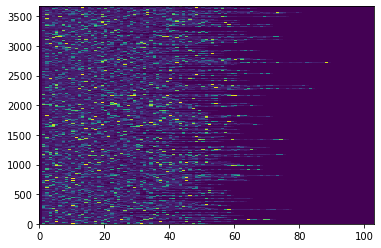

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

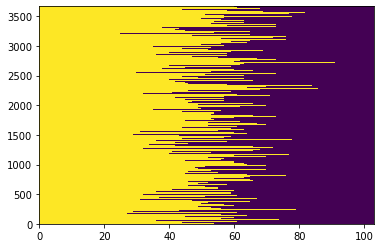

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of. 

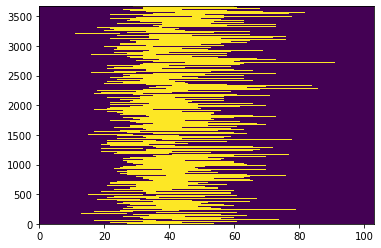

In [18]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the `glue/mrpc` dataset.

In [19]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [20]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [21]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [22]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [23]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

The classifier has three inputs and one output:

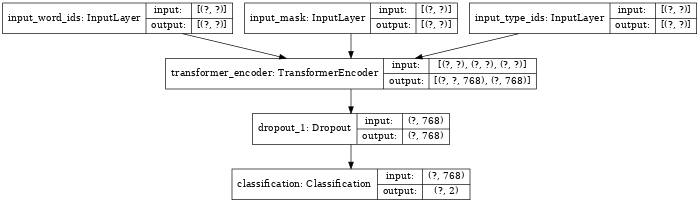

In [24]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [25]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.05488977, -0.26042116],
       [ 0.11358108, -0.09727937],
       [ 0.14350253, -0.2465629 ],
       [ 0.2775127 , -0.09028438],
       [ 0.3606584 , -0.17138724],
       [ 0.3287397 , -0.14672714],
       [ 0.18621178, -0.13080403],
       [ 0.21898738,  0.10716071],
       [ 0.18413854, -0.13491377],
       [ 0.20307963, -0.05396855]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

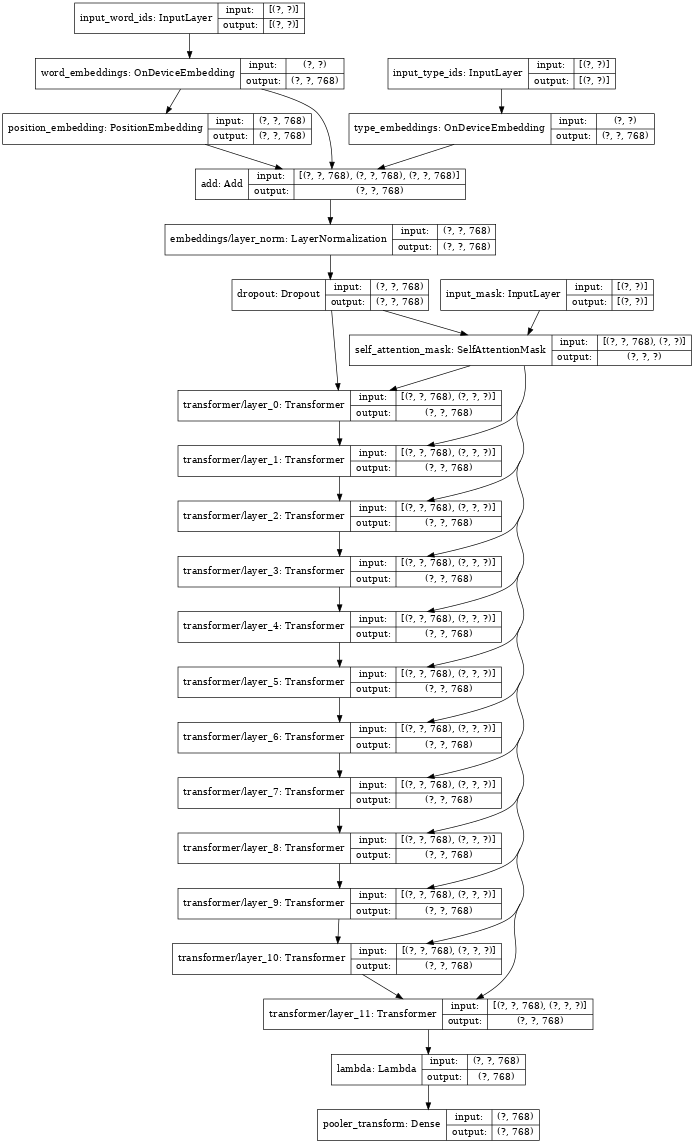

In [26]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [27]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [28]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [29]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

To see an example of how to customize the optimizer and it's schedule, see the [Optimizer schedule appendix](#optiizer_schedule).

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [30]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3


  1/115 [..............................] - ETA: 11s - loss: 1.2259 - accuracy: 0.3750

  2/115 [..............................] - ETA: 17s - loss: 1.2030 - accuracy: 0.3906

  3/115 [..............................] - ETA: 18s - loss: 1.1863 - accuracy: 0.3958

  4/115 [>.............................] - ETA: 19s - loss: 1.2386 - accuracy: 0.3594

  5/115 [>.............................] - ETA: 20s - loss: 1.1817 - accuracy: 0.3938

  6/115 [>.............................] - ETA: 20s - loss: 1.2016 - accuracy: 0.3802

  7/115 [>.............................] - ETA: 20s - loss: 1.2353 - accuracy: 0.3571

  8/115 [=>............................] - ETA: 20s - loss: 1.2118 - accuracy: 0.3672

  9/115 [=>............................] - ETA: 20s - loss: 1.2483 - accuracy: 0.3438

 10/115 [=>............................] - ETA: 20s - loss: 1.2584 - accuracy: 0.3344

 11/115 [=>............................] - ETA: 20s - loss: 1.2647 - accuracy: 0.3295

 12/115 [==>...........................] - ETA: 20s - loss: 1.2518 - accuracy: 0.3333

 13/115 [==>...........................] - ETA: 19s - loss: 1.2367 - accuracy: 0.3413

 14/115 [==>...........................] - ETA: 19s - loss: 1.2381 - accuracy: 0.3348

 15/115 [==>...........................] - ETA: 19s - loss: 1.2311 - accuracy: 0.3354

 16/115 [===>..........................] - ETA: 19s - loss: 1.2153 - accuracy: 0.3418

 17/115 [===>..........................] - ETA: 19s - loss: 1.2092 - accuracy: 0.3401

 18/115 [===>..........................] - ETA: 19s - loss: 1.1934 - accuracy: 0.3455

 19/115 [===>..........................] - ETA: 18s - loss: 1.1830 - accuracy: 0.3421

 20/115 [====>.........................] - ETA: 18s - loss: 1.1750 - accuracy: 0.3375

 21/115 [====>.........................] - ETA: 18s - loss: 1.1608 - accuracy: 0.3363

 22/115 [====>.........................] - ETA: 18s - loss: 1.1435 - accuracy: 0.3395

 23/115 [=====>........................] - ETA: 18s - loss: 1.1264 - accuracy: 0.3370

 24/115 [=====>........................] - ETA: 18s - loss: 1.1095 - accuracy: 0.3411

 25/115 [=====>........................] - ETA: 17s - loss: 1.0934 - accuracy: 0.3450

 26/115 [=====>........................] - ETA: 17s - loss: 1.0773 - accuracy: 0.3570

 27/115 [======>.......................] - ETA: 17s - loss: 1.0622 - accuracy: 0.3669

 28/115 [======>.......................] - ETA: 17s - loss: 1.0475 - accuracy: 0.3795

 29/115 [======>.......................] - ETA: 17s - loss: 1.0342 - accuracy: 0.3879

 30/115 [======>.......................] - ETA: 17s - loss: 1.0208 - accuracy: 0.4010

 31/115 [=======>......................] - ETA: 16s - loss: 1.0075 - accuracy: 0.4123

 32/115 [=======>......................] - ETA: 16s - loss: 0.9962 - accuracy: 0.4199

 33/115 [=======>......................] - ETA: 16s - loss: 0.9856 - accuracy: 0.4261

 34/115 [=======>......................] - ETA: 16s - loss: 0.9739 - accuracy: 0.4366

 35/115 [========>.....................] - ETA: 16s - loss: 0.9631 - accuracy: 0.4455

 36/115 [========>.....................] - ETA: 15s - loss: 0.9557 - accuracy: 0.4497

 37/115 [========>.....................] - ETA: 15s - loss: 0.9458 - accuracy: 0.4578

 38/115 [========>.....................] - ETA: 15s - loss: 0.9352 - accuracy: 0.4655

 39/115 [=========>....................] - ETA: 15s - loss: 0.9273 - accuracy: 0.4712

 40/115 [=========>....................] - ETA: 15s - loss: 0.9188 - accuracy: 0.4773

 41/115 [=========>....................] - ETA: 14s - loss: 0.9120 - accuracy: 0.4817

 42/115 [=========>....................] - ETA: 14s - loss: 0.9037 - accuracy: 0.4881

 43/115 [==========>...................] - ETA: 14s - loss: 0.9001 - accuracy: 0.4898

 44/115 [==========>...................] - ETA: 14s - loss: 0.8959 - accuracy: 0.4922

 45/115 [==========>...................] - ETA: 14s - loss: 0.8882 - accuracy: 0.4979

 46/115 [===========>..................] - ETA: 13s - loss: 0.8834 - accuracy: 0.5000

 47/115 [===========>..................] - ETA: 13s - loss: 0.8765 - accuracy: 0.5053

 48/115 [===========>..................] - ETA: 13s - loss: 0.8702 - accuracy: 0.5098

 49/115 [===========>..................] - ETA: 13s - loss: 0.8629 - accuracy: 0.5153

 50/115 [============>.................] - ETA: 13s - loss: 0.8571 - accuracy: 0.5194

 51/115 [============>.................] - ETA: 12s - loss: 0.8532 - accuracy: 0.5208

 52/115 [============>.................] - ETA: 12s - loss: 0.8464 - accuracy: 0.5264

 53/115 [============>.................] - ETA: 12s - loss: 0.8425 - accuracy: 0.5283

 54/115 [=============>................] - ETA: 12s - loss: 0.8371 - accuracy: 0.5318

 55/115 [=============>................] - ETA: 12s - loss: 0.8324 - accuracy: 0.5352

 56/115 [=============>................] - ETA: 11s - loss: 0.8295 - accuracy: 0.5374

 57/115 [=============>................] - ETA: 11s - loss: 0.8249 - accuracy: 0.5406

 58/115 [==============>...............] - ETA: 11s - loss: 0.8211 - accuracy: 0.5431

 59/115 [==============>...............] - ETA: 11s - loss: 0.8176 - accuracy: 0.5461

 60/115 [==============>...............] - ETA: 11s - loss: 0.8142 - accuracy: 0.5479

 61/115 [==============>...............] - ETA: 10s - loss: 0.8113 - accuracy: 0.5492

 62/115 [===============>..............] - ETA: 10s - loss: 0.8076 - accuracy: 0.5514

 63/115 [===============>..............] - ETA: 10s - loss: 0.8045 - accuracy: 0.5536

 64/115 [===============>..............] - ETA: 10s - loss: 0.8017 - accuracy: 0.5552

 65/115 [===============>..............] - ETA: 10s - loss: 0.7965 - accuracy: 0.5596

 66/115 [================>.............] - ETA: 9s - loss: 0.7945 - accuracy: 0.5601 

 67/115 [================>.............] - ETA: 9s - loss: 0.7911 - accuracy: 0.5625

 68/115 [================>.............] - ETA: 9s - loss: 0.7875 - accuracy: 0.5643

 69/115 [=================>............] - ETA: 9s - loss: 0.7831 - accuracy: 0.5670

 70/115 [=================>............] - ETA: 9s - loss: 0.7794 - accuracy: 0.5701

 71/115 [=================>............] - ETA: 8s - loss: 0.7754 - accuracy: 0.5731

 72/115 [=================>............] - ETA: 8s - loss: 0.7731 - accuracy: 0.5751

 73/115 [==================>...........] - ETA: 8s - loss: 0.7721 - accuracy: 0.5758

 74/115 [==================>...........] - ETA: 8s - loss: 0.7692 - accuracy: 0.5777

 75/115 [==================>...........] - ETA: 8s - loss: 0.7686 - accuracy: 0.5779

 76/115 [==================>...........] - ETA: 7s - loss: 0.7668 - accuracy: 0.5789

 77/115 [===================>..........] - ETA: 7s - loss: 0.7629 - accuracy: 0.5816

 78/115 [===================>..........] - ETA: 7s - loss: 0.7599 - accuracy: 0.5837

 79/115 [===================>..........] - ETA: 7s - loss: 0.7583 - accuracy: 0.5843

 80/115 [===================>..........] - ETA: 7s - loss: 0.7567 - accuracy: 0.5840

 81/115 [====================>.........] - ETA: 6s - loss: 0.7542 - accuracy: 0.5853

 82/115 [====================>.........] - ETA: 6s - loss: 0.7534 - accuracy: 0.5842

 83/115 [====================>.........] - ETA: 6s - loss: 0.7500 - accuracy: 0.5870

 84/115 [====================>.........] - ETA: 6s - loss: 0.7483 - accuracy: 0.5874

 85/115 [=====================>........] - ETA: 6s - loss: 0.7463 - accuracy: 0.5882

 86/115 [=====================>........] - ETA: 5s - loss: 0.7447 - accuracy: 0.5879

 87/115 [=====================>........] - ETA: 5s - loss: 0.7438 - accuracy: 0.5876

 88/115 [=====================>........] - ETA: 5s - loss: 0.7414 - accuracy: 0.5891

 89/115 [======================>.......] - ETA: 5s - loss: 0.7403 - accuracy: 0.5892

 90/115 [======================>.......] - ETA: 5s - loss: 0.7383 - accuracy: 0.5903

 91/115 [======================>.......] - ETA: 4s - loss: 0.7366 - accuracy: 0.5913

 92/115 [=======================>......] - ETA: 4s - loss: 0.7358 - accuracy: 0.5921

 93/115 [=======================>......] - ETA: 4s - loss: 0.7344 - accuracy: 0.5924

 94/115 [=======================>......] - ETA: 4s - loss: 0.7333 - accuracy: 0.5928

 95/115 [=======================>......] - ETA: 4s - loss: 0.7319 - accuracy: 0.5934

 96/115 [========================>.....] - ETA: 3s - loss: 0.7302 - accuracy: 0.5947

 97/115 [========================>.....] - ETA: 3s - loss: 0.7289 - accuracy: 0.5954

 98/115 [========================>.....] - ETA: 3s - loss: 0.7260 - accuracy: 0.5973

 99/115 [========================>.....] - ETA: 3s - loss: 0.7241 - accuracy: 0.5994

100/115 [=========================>....] - ETA: 3s - loss: 0.7228 - accuracy: 0.5994

101/115 [=========================>....] - ETA: 2s - loss: 0.7212 - accuracy: 0.5993

102/115 [=========================>....] - ETA: 2s - loss: 0.7201 - accuracy: 0.5999

103/115 [=========================>....] - ETA: 2s - loss: 0.7180 - accuracy: 0.6010

104/115 [==========================>...] - ETA: 2s - loss: 0.7167 - accuracy: 0.6016

105/115 [==========================>...] - ETA: 2s - loss: 0.7154 - accuracy: 0.6024

106/115 [==========================>...] - ETA: 1s - loss: 0.7141 - accuracy: 0.6044

107/115 [==========================>...] - ETA: 1s - loss: 0.7128 - accuracy: 0.6046

108/115 [===========================>..] - ETA: 1s - loss: 0.7124 - accuracy: 0.6045

109/115 [===========================>..] - ETA: 1s - loss: 0.7118 - accuracy: 0.6044

110/115 [===========================>..] - ETA: 1s - loss: 0.7104 - accuracy: 0.6062

111/115 [===========================>..] - ETA: 0s - loss: 0.7100 - accuracy: 0.6073

112/115 [============================>.] - ETA: 0s - loss: 0.7094 - accuracy: 0.6066

113/115 [============================>.] - ETA: 0s - loss: 0.7074 - accuracy: 0.6084

114/115 [============================>.] - ETA: 0s - loss: 0.7062 - accuracy: 0.6086

115/115 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.6101

115/115 [==============================] - 25s 218ms/step - loss: 0.7047 - accuracy: 0.6101 - val_loss: 0.5219 - val_accuracy: 0.7181


Epoch 2/3


  1/115 [..............................] - ETA: 10s - loss: 0.4982 - accuracy: 0.7188

  2/115 [..............................] - ETA: 16s - loss: 0.5132 - accuracy: 0.7344

  3/115 [..............................] - ETA: 18s - loss: 0.4737 - accuracy: 0.7500

  4/115 [>.............................] - ETA: 19s - loss: 0.4433 - accuracy: 0.7578

  5/115 [>.............................] - ETA: 19s - loss: 0.4467 - accuracy: 0.7563

  6/115 [>.............................] - ETA: 20s - loss: 0.4889 - accuracy: 0.7344

  7/115 [>.............................] - ETA: 20s - loss: 0.5074 - accuracy: 0.7321

  8/115 [=>............................] - ETA: 20s - loss: 0.5058 - accuracy: 0.7383

  9/115 [=>............................] - ETA: 20s - loss: 0.5098 - accuracy: 0.7396

 10/115 [=>............................] - ETA: 20s - loss: 0.5192 - accuracy: 0.7281

 11/115 [=>............................] - ETA: 20s - loss: 0.5232 - accuracy: 0.7273

 12/115 [==>...........................] - ETA: 20s - loss: 0.5292 - accuracy: 0.7292

 13/115 [==>...........................] - ETA: 20s - loss: 0.5275 - accuracy: 0.7260

 14/115 [==>...........................] - ETA: 20s - loss: 0.5246 - accuracy: 0.7321

 15/115 [==>...........................] - ETA: 20s - loss: 0.5240 - accuracy: 0.7375

 16/115 [===>..........................] - ETA: 19s - loss: 0.5252 - accuracy: 0.7441

 17/115 [===>..........................] - ETA: 19s - loss: 0.5283 - accuracy: 0.7463

 18/115 [===>..........................] - ETA: 19s - loss: 0.5215 - accuracy: 0.7535

 19/115 [===>..........................] - ETA: 19s - loss: 0.5162 - accuracy: 0.7582

 20/115 [====>.........................] - ETA: 19s - loss: 0.5117 - accuracy: 0.7547

 21/115 [====>.........................] - ETA: 19s - loss: 0.5130 - accuracy: 0.7545

 22/115 [====>.........................] - ETA: 19s - loss: 0.5105 - accuracy: 0.7528

 23/115 [=====>........................] - ETA: 18s - loss: 0.5152 - accuracy: 0.7486

 24/115 [=====>........................] - ETA: 18s - loss: 0.5166 - accuracy: 0.7435

 25/115 [=====>........................] - ETA: 18s - loss: 0.5185 - accuracy: 0.7425

 26/115 [=====>........................] - ETA: 18s - loss: 0.5112 - accuracy: 0.7452

 27/115 [======>.......................] - ETA: 18s - loss: 0.5114 - accuracy: 0.7454

 28/115 [======>.......................] - ETA: 17s - loss: 0.5093 - accuracy: 0.7455

 29/115 [======>.......................] - ETA: 17s - loss: 0.5118 - accuracy: 0.7435

 30/115 [======>.......................] - ETA: 17s - loss: 0.5111 - accuracy: 0.7427

 31/115 [=======>......................] - ETA: 17s - loss: 0.5099 - accuracy: 0.7450

 32/115 [=======>......................] - ETA: 16s - loss: 0.5097 - accuracy: 0.7461

 33/115 [=======>......................] - ETA: 16s - loss: 0.5118 - accuracy: 0.7443

 34/115 [=======>......................] - ETA: 16s - loss: 0.5099 - accuracy: 0.7472

 35/115 [========>.....................] - ETA: 16s - loss: 0.5163 - accuracy: 0.7464

 36/115 [========>.....................] - ETA: 16s - loss: 0.5161 - accuracy: 0.7465

 37/115 [========>.....................] - ETA: 15s - loss: 0.5143 - accuracy: 0.7492

 38/115 [========>.....................] - ETA: 15s - loss: 0.5153 - accuracy: 0.7500

 39/115 [=========>....................] - ETA: 15s - loss: 0.5199 - accuracy: 0.7444

 40/115 [=========>....................] - ETA: 15s - loss: 0.5200 - accuracy: 0.7453

 41/115 [=========>....................] - ETA: 15s - loss: 0.5174 - accuracy: 0.7477

 42/115 [=========>....................] - ETA: 14s - loss: 0.5147 - accuracy: 0.7500

 43/115 [==========>...................] - ETA: 14s - loss: 0.5139 - accuracy: 0.7515

 44/115 [==========>...................] - ETA: 14s - loss: 0.5175 - accuracy: 0.7472

 45/115 [==========>...................] - ETA: 14s - loss: 0.5168 - accuracy: 0.7472

 46/115 [===========>..................] - ETA: 14s - loss: 0.5178 - accuracy: 0.7473

 47/115 [===========>..................] - ETA: 13s - loss: 0.5179 - accuracy: 0.7480

 48/115 [===========>..................] - ETA: 13s - loss: 0.5163 - accuracy: 0.7507

 49/115 [===========>..................] - ETA: 13s - loss: 0.5176 - accuracy: 0.7506

 50/115 [============>.................] - ETA: 13s - loss: 0.5194 - accuracy: 0.7494

 51/115 [============>.................] - ETA: 13s - loss: 0.5212 - accuracy: 0.7463

 52/115 [============>.................] - ETA: 12s - loss: 0.5213 - accuracy: 0.7452

 53/115 [============>.................] - ETA: 12s - loss: 0.5235 - accuracy: 0.7441

 54/115 [=============>................] - ETA: 12s - loss: 0.5234 - accuracy: 0.7442

 55/115 [=============>................] - ETA: 12s - loss: 0.5220 - accuracy: 0.7449

 56/115 [=============>................] - ETA: 12s - loss: 0.5242 - accuracy: 0.7444

 57/115 [=============>................] - ETA: 11s - loss: 0.5247 - accuracy: 0.7440

 58/115 [==============>...............] - ETA: 11s - loss: 0.5261 - accuracy: 0.7408

 59/115 [==============>...............] - ETA: 11s - loss: 0.5256 - accuracy: 0.7421

 60/115 [==============>...............] - ETA: 11s - loss: 0.5268 - accuracy: 0.7422

 61/115 [==============>...............] - ETA: 11s - loss: 0.5275 - accuracy: 0.7418

 62/115 [===============>..............] - ETA: 10s - loss: 0.5276 - accuracy: 0.7419

 63/115 [===============>..............] - ETA: 10s - loss: 0.5271 - accuracy: 0.7426

 64/115 [===============>..............] - ETA: 10s - loss: 0.5262 - accuracy: 0.7437

 65/115 [===============>..............] - ETA: 10s - loss: 0.5260 - accuracy: 0.7442

 66/115 [================>.............] - ETA: 9s - loss: 0.5250 - accuracy: 0.7448 

 67/115 [================>.............] - ETA: 9s - loss: 0.5243 - accuracy: 0.7449

 68/115 [================>.............] - ETA: 9s - loss: 0.5245 - accuracy: 0.7449

 69/115 [=================>............] - ETA: 9s - loss: 0.5236 - accuracy: 0.7450

 70/115 [=================>............] - ETA: 9s - loss: 0.5215 - accuracy: 0.7460

 71/115 [=================>............] - ETA: 8s - loss: 0.5217 - accuracy: 0.7465

 72/115 [=================>............] - ETA: 8s - loss: 0.5224 - accuracy: 0.7448

 73/115 [==================>...........] - ETA: 8s - loss: 0.5212 - accuracy: 0.7444

 74/115 [==================>...........] - ETA: 8s - loss: 0.5217 - accuracy: 0.7437

 75/115 [==================>...........] - ETA: 8s - loss: 0.5210 - accuracy: 0.7446

 76/115 [==================>...........] - ETA: 7s - loss: 0.5203 - accuracy: 0.7451

 77/115 [===================>..........] - ETA: 7s - loss: 0.5196 - accuracy: 0.7459

 78/115 [===================>..........] - ETA: 7s - loss: 0.5207 - accuracy: 0.7460

 79/115 [===================>..........] - ETA: 7s - loss: 0.5192 - accuracy: 0.7476

 80/115 [===================>..........] - ETA: 7s - loss: 0.5197 - accuracy: 0.7477

 81/115 [====================>.........] - ETA: 6s - loss: 0.5202 - accuracy: 0.7485

 82/115 [====================>.........] - ETA: 6s - loss: 0.5187 - accuracy: 0.7504

 83/115 [====================>.........] - ETA: 6s - loss: 0.5184 - accuracy: 0.7500

 84/115 [====================>.........] - ETA: 6s - loss: 0.5165 - accuracy: 0.7507

 85/115 [=====================>........] - ETA: 6s - loss: 0.5150 - accuracy: 0.7518

 86/115 [=====================>........] - ETA: 5s - loss: 0.5132 - accuracy: 0.7525

 87/115 [=====================>........] - ETA: 5s - loss: 0.5123 - accuracy: 0.7532

 88/115 [=====================>........] - ETA: 5s - loss: 0.5123 - accuracy: 0.7539

 89/115 [======================>.......] - ETA: 5s - loss: 0.5106 - accuracy: 0.7553

 90/115 [======================>.......] - ETA: 5s - loss: 0.5118 - accuracy: 0.7549

 91/115 [======================>.......] - ETA: 4s - loss: 0.5104 - accuracy: 0.7558

 92/115 [=======================>......] - ETA: 4s - loss: 0.5104 - accuracy: 0.7554

 93/115 [=======================>......] - ETA: 4s - loss: 0.5101 - accuracy: 0.7550

 94/115 [=======================>......] - ETA: 4s - loss: 0.5097 - accuracy: 0.7557

 95/115 [=======================>......] - ETA: 4s - loss: 0.5074 - accuracy: 0.7572

 96/115 [========================>.....] - ETA: 3s - loss: 0.5094 - accuracy: 0.7552

 97/115 [========================>.....] - ETA: 3s - loss: 0.5096 - accuracy: 0.7552

 98/115 [========================>.....] - ETA: 3s - loss: 0.5097 - accuracy: 0.7551

 99/115 [========================>.....] - ETA: 3s - loss: 0.5096 - accuracy: 0.7547

100/115 [=========================>....] - ETA: 3s - loss: 0.5108 - accuracy: 0.7544

101/115 [=========================>....] - ETA: 2s - loss: 0.5106 - accuracy: 0.7543

102/115 [=========================>....] - ETA: 2s - loss: 0.5112 - accuracy: 0.7540

103/115 [=========================>....] - ETA: 2s - loss: 0.5105 - accuracy: 0.7542

104/115 [==========================>...] - ETA: 2s - loss: 0.5107 - accuracy: 0.7533

105/115 [==========================>...] - ETA: 2s - loss: 0.5100 - accuracy: 0.7542

106/115 [==========================>...] - ETA: 1s - loss: 0.5096 - accuracy: 0.7544

107/115 [==========================>...] - ETA: 1s - loss: 0.5084 - accuracy: 0.7553

108/115 [===========================>..] - ETA: 1s - loss: 0.5076 - accuracy: 0.7561

109/115 [===========================>..] - ETA: 1s - loss: 0.5087 - accuracy: 0.7552

110/115 [===========================>..] - ETA: 1s - loss: 0.5080 - accuracy: 0.7557

111/115 [===========================>..] - ETA: 0s - loss: 0.5084 - accuracy: 0.7548

112/115 [============================>.] - ETA: 0s - loss: 0.5077 - accuracy: 0.7556

113/115 [============================>.] - ETA: 0s - loss: 0.5071 - accuracy: 0.7561

114/115 [============================>.] - ETA: 0s - loss: 0.5076 - accuracy: 0.7563

115/115 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7560

115/115 [==============================] - 24s 210ms/step - loss: 0.5068 - accuracy: 0.7560 - val_loss: 0.5047 - val_accuracy: 0.7794


Epoch 3/3


  1/115 [..............................] - ETA: 10s - loss: 0.4179 - accuracy: 0.8125

  2/115 [..............................] - ETA: 16s - loss: 0.4843 - accuracy: 0.7656

  3/115 [..............................] - ETA: 18s - loss: 0.5341 - accuracy: 0.7292

  4/115 [>.............................] - ETA: 19s - loss: 0.5184 - accuracy: 0.7422

  5/115 [>.............................] - ETA: 19s - loss: 0.4905 - accuracy: 0.7625

  6/115 [>.............................] - ETA: 20s - loss: 0.5045 - accuracy: 0.7604

  7/115 [>.............................] - ETA: 20s - loss: 0.4774 - accuracy: 0.7723

  8/115 [=>............................] - ETA: 20s - loss: 0.4669 - accuracy: 0.7773

  9/115 [=>............................] - ETA: 20s - loss: 0.4644 - accuracy: 0.7743

 10/115 [=>............................] - ETA: 20s - loss: 0.4620 - accuracy: 0.7781

 11/115 [=>............................] - ETA: 20s - loss: 0.4518 - accuracy: 0.7869

 12/115 [==>...........................] - ETA: 20s - loss: 0.4390 - accuracy: 0.7943

 13/115 [==>...........................] - ETA: 19s - loss: 0.4391 - accuracy: 0.7981

 14/115 [==>...........................] - ETA: 19s - loss: 0.4424 - accuracy: 0.7969

 15/115 [==>...........................] - ETA: 19s - loss: 0.4388 - accuracy: 0.7979

 16/115 [===>..........................] - ETA: 19s - loss: 0.4400 - accuracy: 0.8008

 17/115 [===>..........................] - ETA: 19s - loss: 0.4355 - accuracy: 0.8070

 18/115 [===>..........................] - ETA: 19s - loss: 0.4314 - accuracy: 0.8090

 19/115 [===>..........................] - ETA: 18s - loss: 0.4272 - accuracy: 0.8092

 20/115 [====>.........................] - ETA: 18s - loss: 0.4240 - accuracy: 0.8094

 21/115 [====>.........................] - ETA: 18s - loss: 0.4216 - accuracy: 0.8125

 22/115 [====>.........................] - ETA: 18s - loss: 0.4209 - accuracy: 0.8139

 23/115 [=====>........................] - ETA: 18s - loss: 0.4145 - accuracy: 0.8179

 24/115 [=====>........................] - ETA: 18s - loss: 0.4145 - accuracy: 0.8138

 25/115 [=====>........................] - ETA: 17s - loss: 0.4133 - accuracy: 0.8125

 26/115 [=====>........................] - ETA: 17s - loss: 0.4160 - accuracy: 0.8101

 27/115 [======>.......................] - ETA: 17s - loss: 0.4165 - accuracy: 0.8113

 28/115 [======>.......................] - ETA: 17s - loss: 0.4215 - accuracy: 0.8080

 29/115 [======>.......................] - ETA: 17s - loss: 0.4212 - accuracy: 0.8082

 30/115 [======>.......................] - ETA: 16s - loss: 0.4215 - accuracy: 0.8083

 31/115 [=======>......................] - ETA: 16s - loss: 0.4173 - accuracy: 0.8115

 32/115 [=======>......................] - ETA: 16s - loss: 0.4162 - accuracy: 0.8135

 33/115 [=======>......................] - ETA: 16s - loss: 0.4142 - accuracy: 0.8163

 34/115 [=======>......................] - ETA: 16s - loss: 0.4154 - accuracy: 0.8162

 35/115 [========>.....................] - ETA: 16s - loss: 0.4167 - accuracy: 0.8152

 36/115 [========>.....................] - ETA: 15s - loss: 0.4135 - accuracy: 0.8177

 37/115 [========>.....................] - ETA: 15s - loss: 0.4158 - accuracy: 0.8150

 38/115 [========>.....................] - ETA: 15s - loss: 0.4105 - accuracy: 0.8191

 39/115 [=========>....................] - ETA: 15s - loss: 0.4077 - accuracy: 0.8213

 40/115 [=========>....................] - ETA: 15s - loss: 0.4068 - accuracy: 0.8203

 41/115 [=========>....................] - ETA: 14s - loss: 0.4051 - accuracy: 0.8209

 42/115 [=========>....................] - ETA: 14s - loss: 0.4019 - accuracy: 0.8222

 43/115 [==========>...................] - ETA: 14s - loss: 0.4052 - accuracy: 0.8190

 44/115 [==========>...................] - ETA: 14s - loss: 0.4026 - accuracy: 0.8203

 45/115 [==========>...................] - ETA: 14s - loss: 0.4019 - accuracy: 0.8208

 46/115 [===========>..................] - ETA: 13s - loss: 0.4002 - accuracy: 0.8234

 47/115 [===========>..................] - ETA: 13s - loss: 0.3975 - accuracy: 0.8238

 48/115 [===========>..................] - ETA: 13s - loss: 0.3984 - accuracy: 0.8236

 49/115 [===========>..................] - ETA: 13s - loss: 0.4018 - accuracy: 0.8227

 50/115 [============>.................] - ETA: 13s - loss: 0.4010 - accuracy: 0.8238

 51/115 [============>.................] - ETA: 12s - loss: 0.3984 - accuracy: 0.8241

 52/115 [============>.................] - ETA: 12s - loss: 0.3959 - accuracy: 0.8257

 53/115 [============>.................] - ETA: 12s - loss: 0.3927 - accuracy: 0.8284

 54/115 [=============>................] - ETA: 12s - loss: 0.3924 - accuracy: 0.8281

 55/115 [=============>................] - ETA: 12s - loss: 0.3945 - accuracy: 0.8256

 56/115 [=============>................] - ETA: 11s - loss: 0.3945 - accuracy: 0.8253

 57/115 [=============>................] - ETA: 11s - loss: 0.3937 - accuracy: 0.8268

 58/115 [==============>...............] - ETA: 11s - loss: 0.3935 - accuracy: 0.8254

 59/115 [==============>...............] - ETA: 11s - loss: 0.3934 - accuracy: 0.8247

 60/115 [==============>...............] - ETA: 11s - loss: 0.3906 - accuracy: 0.8271

 61/115 [==============>...............] - ETA: 10s - loss: 0.3919 - accuracy: 0.8258

 62/115 [===============>..............] - ETA: 10s - loss: 0.3907 - accuracy: 0.8271

 63/115 [===============>..............] - ETA: 10s - loss: 0.3901 - accuracy: 0.8274

 64/115 [===============>..............] - ETA: 10s - loss: 0.3924 - accuracy: 0.8271

 65/115 [===============>..............] - ETA: 10s - loss: 0.3921 - accuracy: 0.8279

 66/115 [================>.............] - ETA: 9s - loss: 0.3911 - accuracy: 0.8291 

 67/115 [================>.............] - ETA: 9s - loss: 0.3914 - accuracy: 0.8298

 68/115 [================>.............] - ETA: 9s - loss: 0.3901 - accuracy: 0.8300

 69/115 [=================>............] - ETA: 9s - loss: 0.3879 - accuracy: 0.8315

 70/115 [=================>............] - ETA: 9s - loss: 0.3859 - accuracy: 0.8330

 71/115 [=================>............] - ETA: 8s - loss: 0.3848 - accuracy: 0.8332

 72/115 [=================>............] - ETA: 8s - loss: 0.3865 - accuracy: 0.8329

 73/115 [==================>...........] - ETA: 8s - loss: 0.3850 - accuracy: 0.8330

 74/115 [==================>...........] - ETA: 8s - loss: 0.3844 - accuracy: 0.8332

 75/115 [==================>...........] - ETA: 8s - loss: 0.3834 - accuracy: 0.8338

 76/115 [==================>...........] - ETA: 7s - loss: 0.3822 - accuracy: 0.8339

 77/115 [===================>..........] - ETA: 7s - loss: 0.3823 - accuracy: 0.8328

 78/115 [===================>..........] - ETA: 7s - loss: 0.3824 - accuracy: 0.8325

 79/115 [===================>..........] - ETA: 7s - loss: 0.3838 - accuracy: 0.8319

 80/115 [===================>..........] - ETA: 7s - loss: 0.3833 - accuracy: 0.8324

 81/115 [====================>.........] - ETA: 6s - loss: 0.3820 - accuracy: 0.8333

 82/115 [====================>.........] - ETA: 6s - loss: 0.3815 - accuracy: 0.8335

 83/115 [====================>.........] - ETA: 6s - loss: 0.3820 - accuracy: 0.8336

 84/115 [====================>.........] - ETA: 6s - loss: 0.3830 - accuracy: 0.8337

 85/115 [=====================>........] - ETA: 6s - loss: 0.3842 - accuracy: 0.8331

 86/115 [=====================>........] - ETA: 5s - loss: 0.3840 - accuracy: 0.8325

 87/115 [=====================>........] - ETA: 5s - loss: 0.3831 - accuracy: 0.8330

 88/115 [=====================>........] - ETA: 5s - loss: 0.3838 - accuracy: 0.8331

 89/115 [======================>.......] - ETA: 5s - loss: 0.3823 - accuracy: 0.8343

 90/115 [======================>.......] - ETA: 5s - loss: 0.3816 - accuracy: 0.8344

 91/115 [======================>.......] - ETA: 4s - loss: 0.3833 - accuracy: 0.8331

 92/115 [=======================>......] - ETA: 4s - loss: 0.3830 - accuracy: 0.8332

 93/115 [=======================>......] - ETA: 4s - loss: 0.3831 - accuracy: 0.8333

 94/115 [=======================>......] - ETA: 4s - loss: 0.3841 - accuracy: 0.8318

 95/115 [=======================>......] - ETA: 4s - loss: 0.3842 - accuracy: 0.8319

 96/115 [========================>.....] - ETA: 3s - loss: 0.3837 - accuracy: 0.8320

 97/115 [========================>.....] - ETA: 3s - loss: 0.3830 - accuracy: 0.8328

 98/115 [========================>.....] - ETA: 3s - loss: 0.3825 - accuracy: 0.8326

 99/115 [========================>.....] - ETA: 3s - loss: 0.3832 - accuracy: 0.8327

100/115 [=========================>....] - ETA: 3s - loss: 0.3830 - accuracy: 0.8328

101/115 [=========================>....] - ETA: 2s - loss: 0.3818 - accuracy: 0.8335

102/115 [=========================>....] - ETA: 2s - loss: 0.3813 - accuracy: 0.8339

103/115 [=========================>....] - ETA: 2s - loss: 0.3811 - accuracy: 0.8334

104/115 [==========================>...] - ETA: 2s - loss: 0.3811 - accuracy: 0.8338

105/115 [==========================>...] - ETA: 2s - loss: 0.3825 - accuracy: 0.8327

106/115 [==========================>...] - ETA: 1s - loss: 0.3824 - accuracy: 0.8331

107/115 [==========================>...] - ETA: 1s - loss: 0.3823 - accuracy: 0.8329

108/115 [===========================>..] - ETA: 1s - loss: 0.3819 - accuracy: 0.8336

109/115 [===========================>..] - ETA: 1s - loss: 0.3818 - accuracy: 0.8343

110/115 [===========================>..] - ETA: 1s - loss: 0.3818 - accuracy: 0.8341

111/115 [===========================>..] - ETA: 0s - loss: 0.3831 - accuracy: 0.8331

112/115 [============================>.] - ETA: 0s - loss: 0.3824 - accuracy: 0.8329

113/115 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8327

114/115 [============================>.] - ETA: 0s - loss: 0.3819 - accuracy: 0.8328

115/115 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8332

115/115 [==============================] - 24s 209ms/step - loss: 0.3812 - accuracy: 0.8332 - val_loss: 0.4839 - val_accuracy: 0.8137


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [31]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [32]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [33]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

### Save the model

Often the goal of training a model is to _use_ it for something, so export the model and then restore it to be sure that it works.

In [34]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [35]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.1238481   0.92107666]
 [ 0.35722053 -0.4061358 ]]

[[-1.1238478   0.9210764 ]
 [ 0.35722044 -0.40613574]]


## Appendix

<a id=re_encoding_tools></a>
### Re-encoding a large dataset

This tutorial you re-encoded the dataset in memory, for clarity.

This was only possible because `glue/mrpc` is a very small dataset. To deal with larger datasets `tf_models` library includes some tools for processing and re-encoding a dataset for efficient training.

The first step is to describe which features of the dataset should be transformed:

In [36]:
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)

Then apply the transformation to generate new TFRecord files.

In [37]:
# Set up output of training and evaluation Tensorflow dataset
train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

# Generate and save training data into a tf record file
input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,
      data_dir=None,  # It is `None` because data is from tfds, not local dir.
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

Finally create `tf.data` input pipelines from those TFRecord files:

In [38]:
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by `keras.Model.fit`:

In [39]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### Create tf.data.Dataset for training and evaluation


If you need to modify the data loading here is some code to get you started:

In [40]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  """Creates input dataset from (tf)records files for train/eval."""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [41]:
# Set up batch sizes
batch_size = 32
eval_batch_size = 32

# Return Tensorflow dataset
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

In [42]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

<a id="hub_bert"></a>

### TFModels BERT on TFHub

You can get [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) off the shelf from [TFHub](https://tensorflow.org/hub). It would not be hard to add a classification head on top of this `hub.KerasLayer`

In [43]:
# Note: 350MB download.
import tensorflow_hub as hub
hub_encoder = hub.KerasLayer(hub_url_bert, trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


Test run it on a batch of data:

In [44]:
result = hub_encoder(
    inputs=[glue_train['input_word_ids'][:10],
            glue_train['input_mask'][:10],
            glue_train['input_type_ids'][:10],],
    training=False,
)

print("Pooled output shape:", result[0].shape)
print("Sequence output shape:", result[1].shape)

Pooled output shape: (10, 768)
Sequence output shape: (10, 103, 768)


At this point it would be simple to add a classification head yourself.

The `bert_models.classifier_model` function can also build a classifier onto the encoder from TensorFlow Hub:

In [45]:
hub_classifier, hub_encoder = bert.bert_models.classifier_model(
    # Caution: Most of `bert_config` is ignored if you pass a hub url.
    bert_config=bert_config, hub_module_url=hub_url_bert, num_labels=2)

The one downside to loading this model from TFHub is that the structure of internal keras layers is not restored. So it's more difficult to inspect or modify the model. The `TransformerEncoder` model is now a single layer:

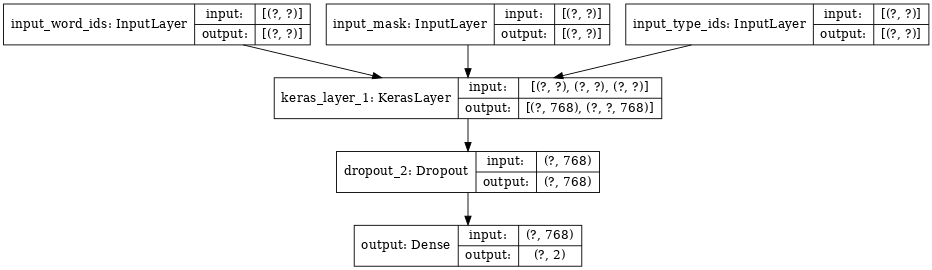

In [46]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [47]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'


<a id="model_builder_functions"></a>

### Low level model building

If you need a more control over the construction of the model it's worth noting that the `classifier_model` function used earlier is really just a thin wrapper over the `nlp.modeling.networks.TransformerEncoder` and `nlp.modeling.models.BertClassifier` classes. Just remember that if you start modifying the architecture it may not be correct or possible to reload the pre-trained checkpoint so you'll need to retrain from scratch.

Build the encoder:

In [48]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'hidden_size': 768,
 'intermediate_size': 3072,
 'num_attention_heads': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522,
 'attention_dropout_rate': 0.1,
 'activation': <function official.modeling.activations.gelu.gelu(x)>,
 'dropout_rate': 0.1,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f81145cb3c8>,
 'max_sequence_length': 512,
 'num_layers': 12}

In [49]:
manual_encoder = nlp.modeling.networks.TransformerEncoder(**transformer_config)

Restore the weights:

In [50]:
checkpoint = tf.train.Checkpoint(model=manual_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Test run it:

In [51]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 23, 768)
Pooled output shape: (2, 768)


Wrap it in a classifier:

In [52]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [53]:
manual_classifier(my_examples, training=True).numpy()

array([[-0.22512403,  0.07213479],
       [-0.21233292,  0.1311737 ]], dtype=float32)

<a id="optiizer_schedule"></a>

### Optimizers and schedules

The optimizer used to train the model was created using the `nlp.optimization.create_optimizer` function:

In [54]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

That high level wrapper sets up the learning rate schedules and the optimizer.

The base learning rate schedule used here is a linear decay to zero over the training run:

In [55]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

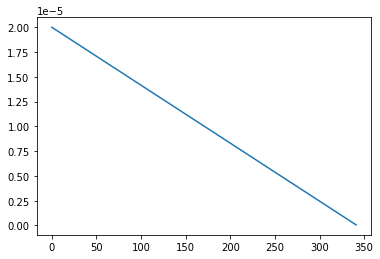

In [56]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

This, in turn is wrapped in a `WarmUp` schedule that linearly increases the learning rate to the target value over the first 10% of training:

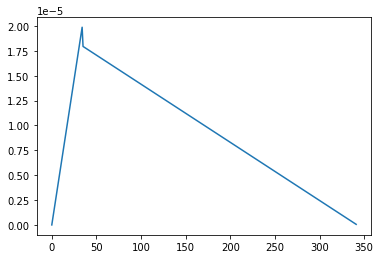

In [57]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# The warmup overshoots, because it warms up to the `initial_learning_rate`
# following the original implementation. You can set
# `initial_learning_rate=decay_schedule(warmup_steps)` if you don't like the
# overshoot.
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

Then create the `nlp.optimization.AdamWeightDecay` using that schedule, configured for the BERT model:

In [58]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])